# Exam Score Prediction (Regression)

**Goal:** Predict students' `exam_score` 
**Dataset:** `Exam_Score_Prediction.csv` 




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


## 1) Load data and quick overview

In [7]:
# Load dataset (make sure the CSV is in the same folder as this notebook)
df = pd.read_csv("Exam_Score_Prediction.csv")

print("Shape:", df.shape)
display(df.head())
df.info()


Shape: (20000, 13)


,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


## 2) Data quality

In [8]:
# Data quality checks
print("Duplicates:", df.duplicated().sum())
print("\nMissing values per column:")
display(df.isnull().sum().sort_values(ascending=False))

# Unique values overview (helpful for categorical columns)
display(df.nunique().sort_values())


Duplicates: 0

Missing values per column:


student_id          0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

internet_access         2
gender                  3
facility_rating         3
sleep_quality           3
exam_difficulty         3
study_method            5
course                  7
age                     8
sleep_hours            59
class_attendance      589
study_hours           784
exam_score            805
student_id          20000
dtype: int64

## 3) Exploratory Data Analysis and Visualization

### 3.1 Numeric feature distributions

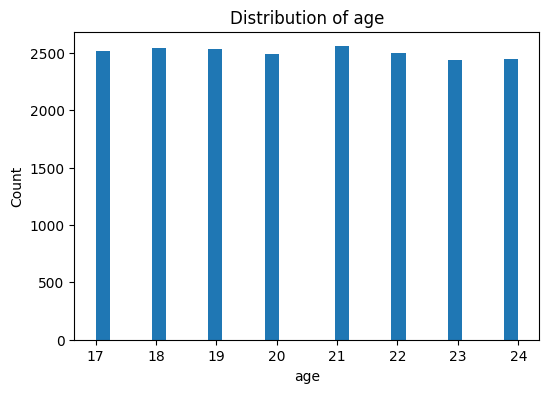

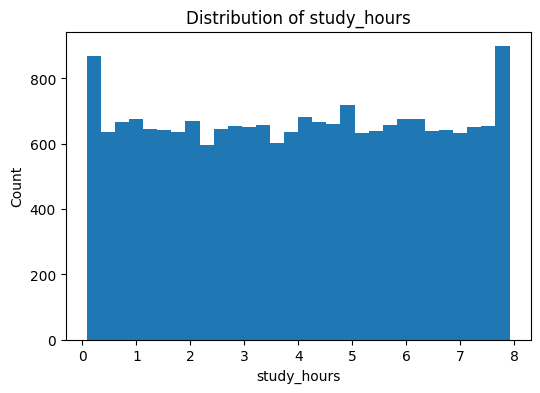

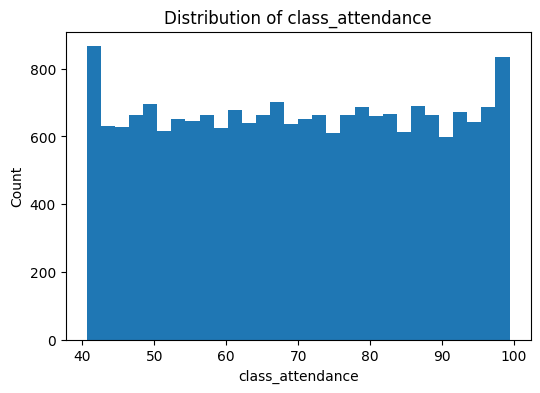

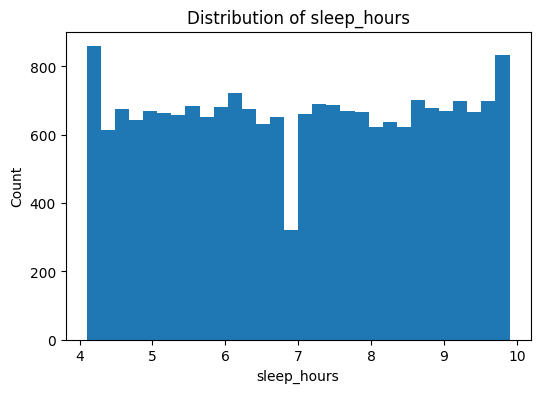

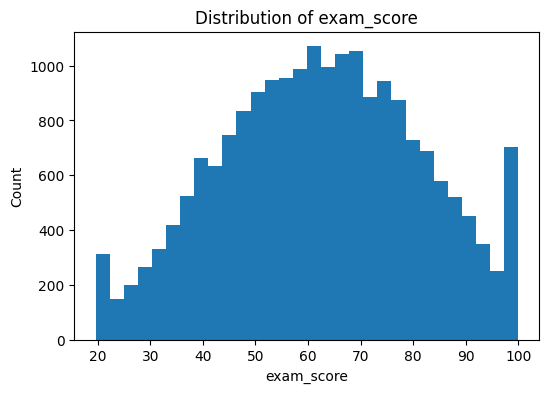

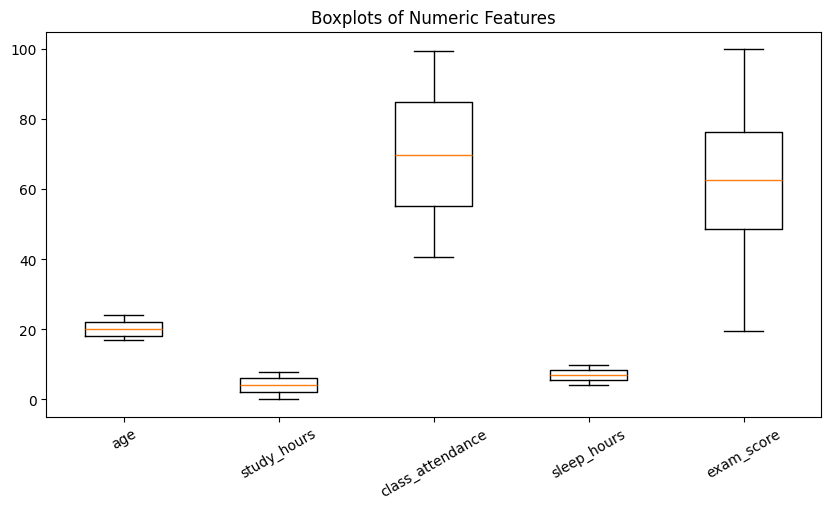

In [9]:
num_cols = ["age", "study_hours", "class_attendance", "sleep_hours", "exam_score"]

for c in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[c], bins=30)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()

# Boxplots for numeric columns
plt.figure(figsize=(10,5))
plt.boxplot([df[c] for c in num_cols], tick_labels=num_cols)
plt.title("Boxplots of Numeric Features")
plt.xticks(rotation=30)
plt.show()


### 3.2 Relationships with target (`exam_score`)

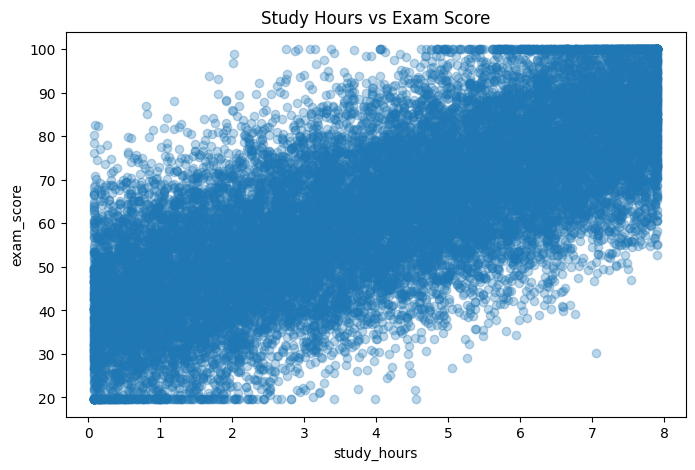

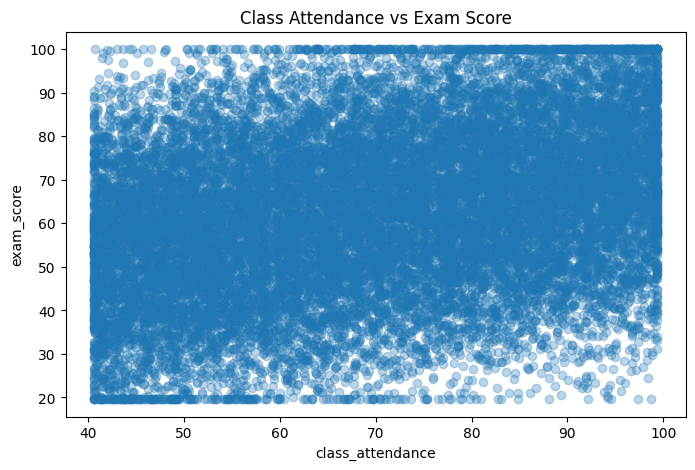

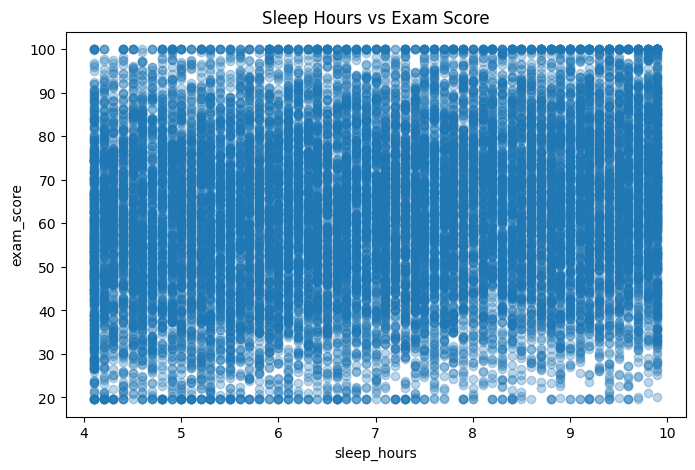

In [10]:
plt.figure(figsize=(8,5))
plt.scatter(df["study_hours"], df["exam_score"], alpha=0.3)
plt.title("Study Hours vs Exam Score")
plt.xlabel("study_hours")
plt.ylabel("exam_score")
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(df["class_attendance"], df["exam_score"], alpha=0.3)
plt.title("Class Attendance vs Exam Score")
plt.xlabel("class_attendance")
plt.ylabel("exam_score")
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(df["sleep_hours"], df["exam_score"], alpha=0.3)
plt.title("Sleep Hours vs Exam Score")
plt.xlabel("sleep_hours")
plt.ylabel("exam_score")
plt.show()


### 3.3 Categorical features impact on scores

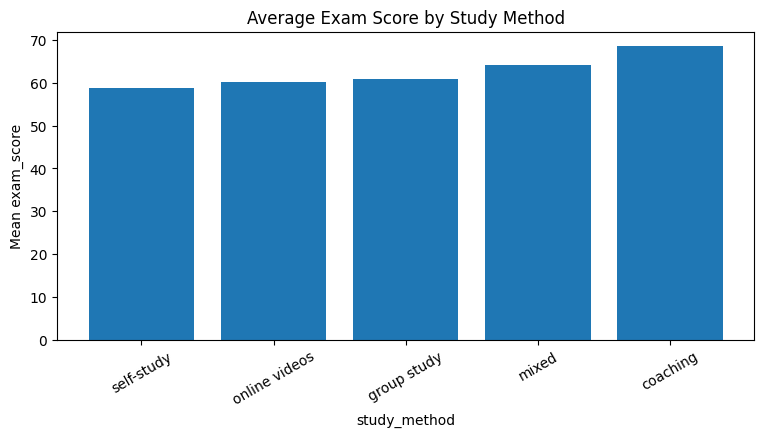

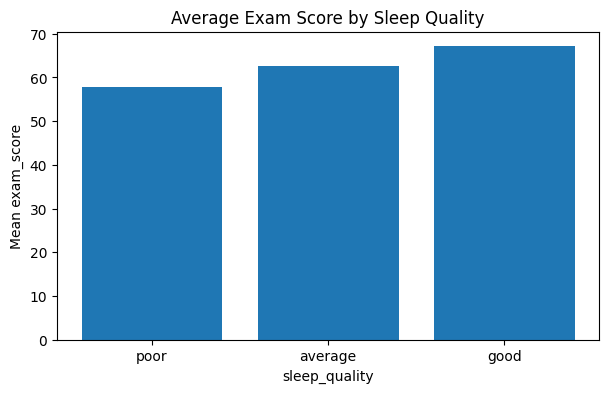

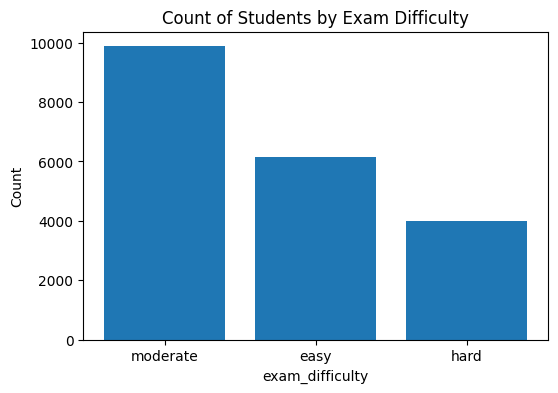

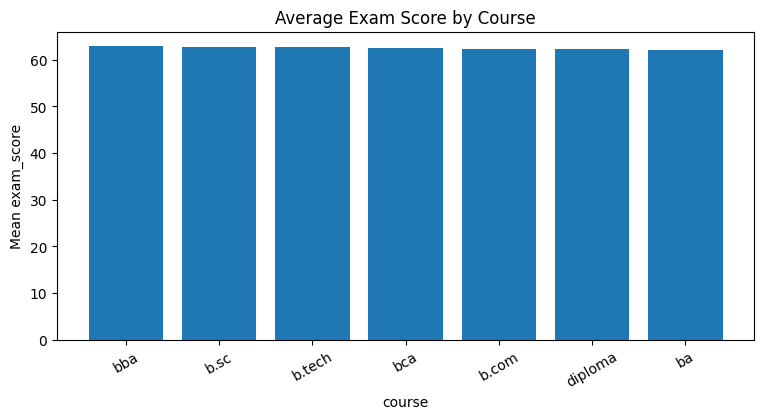

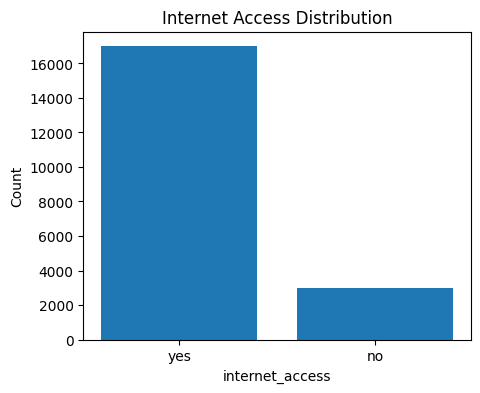

In [11]:
# Study method (your original visualization)
means = df.groupby("study_method")["exam_score"].mean().sort_values()
plt.figure(figsize=(9,4))
plt.bar(means.index, means.values)
plt.title("Average Exam Score by Study Method")
plt.xlabel("study_method")
plt.ylabel("Mean exam_score")
plt.xticks(rotation=30)
plt.show()

# Sleep quality
means = df.groupby("sleep_quality")["exam_score"].mean().sort_values()
plt.figure(figsize=(7,4))
plt.bar(means.index, means.values)
plt.title("Average Exam Score by Sleep Quality")
plt.xlabel("sleep_quality")
plt.ylabel("Mean exam_score")
plt.show()

# Exam difficulty (count)
counts = df["exam_difficulty"].value_counts()
plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.title("Count of Students by Exam Difficulty")
plt.xlabel("exam_difficulty")
plt.ylabel("Count")
plt.show()

# Course (mean score)
means = df.groupby("course")["exam_score"].mean().sort_values(ascending=False)
plt.figure(figsize=(9,4))
plt.bar(means.index.astype(str), means.values)
plt.title("Average Exam Score by Course")
plt.xlabel("course")
plt.ylabel("Mean exam_score")
plt.xticks(rotation=30)
plt.show()

# Internet access (count)
counts = df["internet_access"].value_counts()
plt.figure(figsize=(5,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Internet Access Distribution")
plt.xlabel("internet_access")
plt.ylabel("Count")
plt.show()


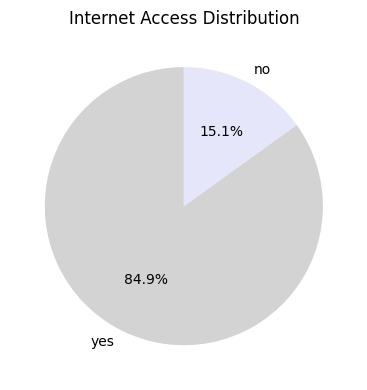

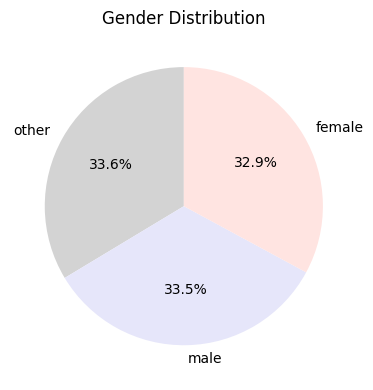

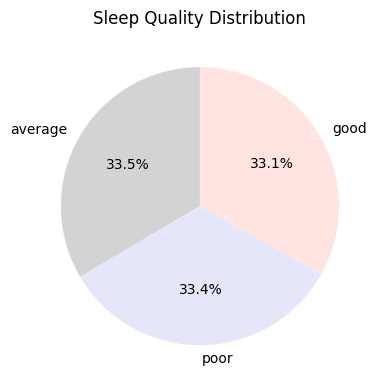

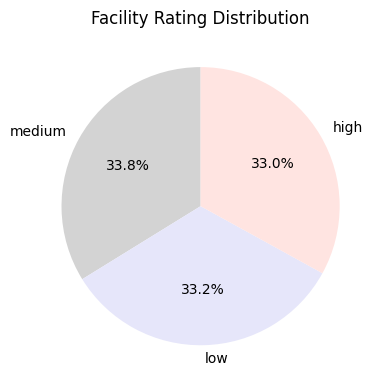

In [12]:

def plot_pie(series, title, colors=("lightgray","lavender","mistyrose")):
    counts = series.value_counts()

    colors_list = [colors[i % len(colors)] for i in range(len(counts))]

    plt.figure(figsize=(4, 4))
    plt.pie(
        counts.values,
        labels=counts.index.astype(str),
        autopct="%1.1f%%",
        startangle=90,
        colors=colors_list
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_pie(df["internet_access"], "Internet Access Distribution")
plot_pie(df["gender"], "Gender Distribution")
plot_pie(df["sleep_quality"], "Sleep Quality Distribution")
plot_pie(df["facility_rating"], "Facility Rating Distribution")


### 3.4 Correlation heatmap (numeric)

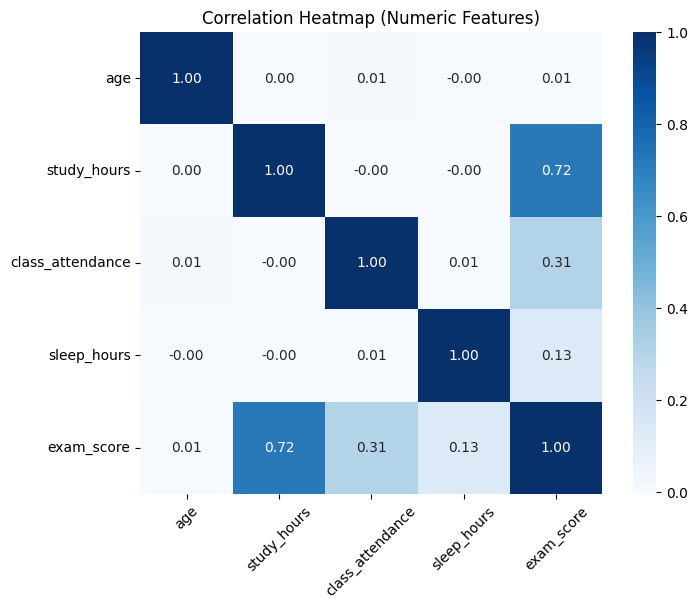

In [13]:
corr_cols = ["age","study_hours","class_attendance","sleep_hours","exam_score"]
corr = df[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f",cmap="Blues", square=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


## 4) Feature engineering and preprocessing

In [ ]:
df_model = df.drop(columns=["student_id"], errors="ignore").copy()

# Map ordinal categories to numbers (keeps 'order' meaning)
sleep_map = {"poor": 1, "average": 2, "good": 3}
diff_map  = {"easy": 1, "moderate": 2, "hard": 3}

df_model["sleep_quality_num"] = df_model["sleep_quality"].astype(str).str.lower().map(sleep_map).fillna(2)
df_model["exam_difficulty_num"] = df_model["exam_difficulty"].astype(str).str.lower().map(diff_map).fillna(2)

# Simple engineered features
df_model["study_consistency"]   = df_model["study_hours"] * df_model["sleep_quality_num"]
df_model["hours_x_difficulty"]  = df_model["study_hours"] * df_model["exam_difficulty_num"]
df_model["stress_index"]        = df_model["study_hours"] / (df_model["sleep_hours"] + 1)
df_model["prep_vs_difficulty"]  = df_model["study_hours"] / (df_model["exam_difficulty_num"] + 0.5)

feature_cols = [
    "age","gender","course","study_hours","class_attendance","internet_access",
    "sleep_hours","sleep_quality","study_method","facility_rating","exam_difficulty",
    "sleep_quality_num","exam_difficulty_num",
    "study_consistency","hours_x_difficulty","stress_index","prep_vs_difficulty"
]

X = df_model[feature_cols]
y = df_model["exam_score"]


X = pd.get_dummies(X, drop_first=True)
X = X.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scaling (needed for SVR/KNN/Linear/Polynomial)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Final feature matrix:", X_train.shape)


Final feature matrix: (16000, 29)


## 5) Modeling ( regression models) + Hyperparameter tuning

In [ ]:
models_config = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Polynomial Regression": {
        "model": "poly", 
        "params": {
            "degree": [2, 3]
        }
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            "n_neighbors": [3, 5, 7, 10, 15],
            "weights": ["uniform", "distance"]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [1, 10, 100],
            "kernel": ["rbf", "linear"],
            "gamma": ["scale", "auto"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [5, 10, 20, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [2, 3, 5]
        }
    }
}


In [ ]:
results = []
best_models = {}

scale_models = {"SVR", "KNN", "Linear Regression", "Polynomial Regression"}

for name, cfg in models_config.items():
    print("\nTraining:", name)
    print("-"*60)

    # Choose scaled vs unscaled features
    if name in scale_models:
        Xtr, Xte = X_train_scaled, X_test_scaled
    else:
        Xtr, Xte = X_train, X_test

    try:
        if name == "Polynomial Regression":
            # GridSearch over degree
            best_r2 = -1
            best_pair = None
            for deg in cfg["params"]["degree"]:
                poly = PolynomialFeatures(degree=deg, include_bias=False)
                Xtr_poly = poly.fit_transform(Xtr)
                Xte_poly = poly.transform(Xte)

                lr = LinearRegression()
                lr.fit(Xtr_poly, y_train)

                pred = lr.predict(Xte_poly)
                r2 = r2_score(y_test, pred)

                if r2 > best_r2:
                    best_r2 = r2
                    best_pair = (poly, lr)

            poly_best, lr_best = best_pair
            best_models[name] = best_pair
            y_pred_train = lr_best.predict(poly_best.transform(Xtr))
            y_pred_test  = lr_best.predict(poly_best.transform(Xte))

        else:
            model = cfg["model"]
            params = cfg["params"]

            if params:
                grid = GridSearchCV(model, params, cv=3, scoring="r2", n_jobs=-1)
                grid.fit(Xtr, y_train)
                best_model = grid.best_estimator_
                print("Best params:", grid.best_params_)
            else:
                best_model = model.fit(Xtr, y_train)

            best_models[name] = best_model
            y_pred_train = best_model.predict(Xtr)
            y_pred_test  = best_model.predict(Xte)

        # Metrics
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2  = r2_score(y_test, y_pred_test)
        rmse     = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae      = mean_absolute_error(y_test, y_pred_test)

        results.append({"Model": name, "Train R2": train_r2, "Test R2": test_r2, "RMSE": rmse, "MAE": mae})

        print(f"Train R2: {train_r2:.4f}")
        print(f"Test  R2: {test_r2:.4f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"MAE : {mae:.3f}")

    except Exception as e:
        print("Error in", name, "->", e)

results_df = pd.DataFrame(results).sort_values("Test R2", ascending=False)
display(results_df)



Training: Linear Regression
------------------------------------------------------------
Train R2: 0.7321
Test  R2: 0.7331
RMSE: 9.771
MAE : 7.862

Training: Polynomial Regression
------------------------------------------------------------
Train R2: 0.7376
Test  R2: 0.7286
RMSE: 9.852
MAE : 7.936

Training: KNN
------------------------------------------------------------
Best params: {'n_neighbors': 15, 'weights': 'distance'}
Train R2: 1.0000
Test  R2: 0.6337
RMSE: 11.447
MAE : 9.292

Training: SVR
------------------------------------------------------------
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Train R2: 0.7318
Test  R2: 0.7327
RMSE: 9.779
MAE : 7.859

Training: Decision Tree
------------------------------------------------------------
Best params: {'max_depth': 5, 'min_samples_split': 2}
Train R2: 0.6368
Test  R2: 0.6239
RMSE: 11.598
MAE : 9.389

Training: Random Forest
------------------------------------------------------------


## 6) Best model evaluation

Scatter plot of **actual vs predicted** for the best test R² model.

BEST MODEL: Linear Regression


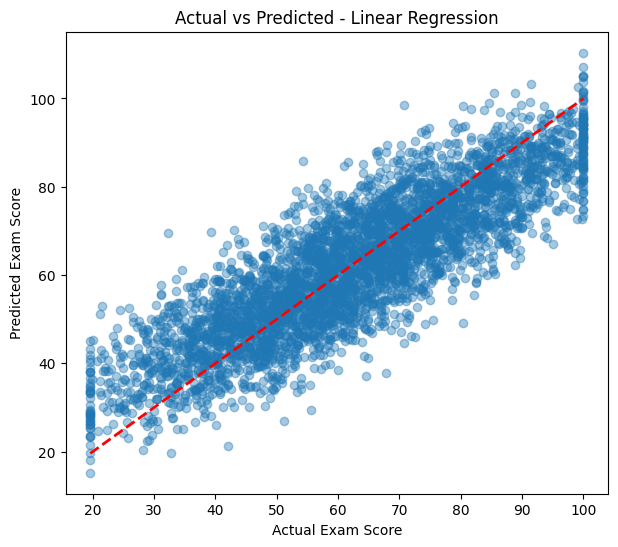

In [ ]:
best_name = results_df.iloc[0]["Model"]
print("BEST MODEL:", best_name)

best_obj = best_models[best_name]

if best_name == "Polynomial Regression":
    poly_best, lin_best = best_obj
    y_pred_best = lin_best.predict(poly_best.transform(X_test_scaled))
else:
    if best_name in {"Decision Tree", "Random Forest", "Gradient Boosting"}:
        y_pred_best = best_obj.predict(X_test)
    else:
        y_pred_best = best_obj.predict(X_test_scaled)

plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred_best, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title(f"Actual vs Predicted - {best_name}")
plt.show()
